In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from llamawrapper import LlamaHelper
from tqdm import tqdm
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

Using device: cuda


In [2]:
input_lang = 'en'
latent_lang_1 = 'fr'
latent_lang_2 = 'zh'
target_lang = 'ja'
model_size = '13b'
model_selected = 2
layer_num = 40
out_dir = './visuals'
# Need a huggingface token for some model
hf_token = ''

In [5]:
# from transformers import AutoTokenizer, AutoModelForCausalLM
# load_in_8bit=True
# use_embed_head=False
# device_map='auto'
# trust_remote_code = True
# cache_directory = '/mnt/berry/data/transformers_cache/'
# tokenizer = AutoTokenizer.from_pretrained(custom_model, use_auth_token=hf_token, trust_remote_code = trust_remote_code, cache_dir=cache_directory)

# model = AutoModelForCausalLM.from_pretrained(custom_model, use_auth_token=hf_token,
#                                                 device_map=device_map,
#                                                 load_in_8bit=load_in_8bit,
#                                                 trust_remote_code = trust_remote_code,
#                                                 cache_dir=cache_directory)


/home/zhong/miniconda3/envs/latent/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:769: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/zhong/miniconda3/envs/latent/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradien

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
if model_selected == 1:
    custom_model = 'llm-jp/llm-jp-13b-v2.0'
elif model_selected == 2:
    custom_model = 'meta-llama/Llama-2-%s-hf'%model_size
elif model_selected == 3:
    custom_model = 'tokyotech-llm/Swallow-%s-hf'%model_size
elif model_selected == 4:
    custom_model = 'hfl/chinese-llama-2-13b'
elif model_selected == 5:
    custom_model = 'baichuan-inc/Baichuan2-13B-Base'
elif model_selected == 6:
    custom_model = 'sambanovasystems/SambaLingo-Arabic-Base'
elif model_selected == 7:
    custom_model = 'OpenLLM-France/Claire-Mistral-7B-0.1'
elif model_selected == 8:
    custom_model = 'croissantllm/CroissantLLMBase'
# elif model_selected == 9:
#     custom_model = 'inceptionai/jais-13b' -- GPT based model

In [ ]:
# Change to your own path
cache_directory = '/mnt/berry/data/transformers_cache/'
if custom_model is not None:
    model = LlamaHelper(dir=custom_model, load_in_8bit=True, hf_token=hf_token,cache_directory=cache_directory)

In [ ]:
tokenizer = model.tokenizer
# from transformers import AutoTokenizer, AutoModelForCausalLM
# trust_remote_code = True
# cache_directory = '/mnt/berry/data/transformers_cache/'
# tokenizer = AutoTokenizer.from_pretrained(custom_model, use_auth_token=hf_token, trust_remote_code = trust_remote_code, cache_dir=cache_directory)

In [6]:
file_path = 'multi5.csv'
df = pd.read_csv(file_path)

In [7]:
def capitalizations(token_str):
    variants = [token_str.lower(), token_str.capitalize()]
    return list(set(variants))

def add_spaces_(tokens):
    return ['▁' + t for t in tokens] + tokens

def add_spaces(tokens):
    return [' ' + t for t in tokens] + tokens

def add_(tokens):
    return ['_' + t for t in tokens]

def ar_(tokens):
    return ['"' + t for t in tokens]

# Obtain all possible tokenizations of a word
def process_tokens(token_str: str, tokenizer, lang):
    final_tokens = []
    # print(token_str)
    if lang in ['en', 'fr']:
        with_capitalizations = capitalizations(token_str)
        if model_selected == 9:
            with_spaces = add_spaces(with_capitalizations)
        else:
            with_spaces = add_spaces_(with_capitalizations)
        finail = with_spaces + add_(with_capitalizations)
        finail = list(set(finail))
        for tok in finail:
            default_tokens = tokenizer.tokenize(tok)
            default_token_ids = tokenizer.convert_tokens_to_ids(default_tokens)

            if tok.startswith('_') and len(default_token_ids) > 1:
                if model_selected == 1:
                    final_tokens.append(default_token_ids[2:])
                else:
                    final_tokens.append(default_token_ids[1:])
            elif model_selected == 1 and lang == 'fr':
                final_tokens.append(default_token_ids[:])
                if default_token_ids[0] == 31:
                    final_tokens.append(default_token_ids[1:])
            else:
                final_tokens.append(default_token_ids)
    elif lang in ['ja', 'zh']:
        finail = ['▁' + token_str] + [token_str]
        for tok in finail:
            default_tokens = tokenizer.tokenize(tok)
            default_token_ids = tokenizer.convert_tokens_to_ids(default_tokens)
            final_tokens.append(default_token_ids)
            if len(default_token_ids) > 1 and model_selected!=5:
                final_tokens.append(default_token_ids[1:])
    elif lang in ['ar']:
        finail = ['▁' + token_str] + [token_str] + ['"' + token_str]
        for tok in finail:
            default_tokens = tokenizer.tokenize(tok)
            default_token_ids = tokenizer.convert_tokens_to_ids(default_tokens)
            if tok.startswith('"'):
                final_tokens.append(default_token_ids[1:])
            else:
                final_tokens.append(default_token_ids)
                if len(default_token_ids) > 1:
                    final_tokens.append(default_token_ids[1:])
    return final_tokens

In [8]:
def remove_duplicates(nested_list):
    if len(nested_list) <= 1:
        return nested_list
    return [list(x) for x in set(tuple(x) for x in nested_list)]

In [9]:
id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'en': 'English', 'zh': '中文', 'ja': '日本語', 'ar': 'عربي'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='zh', lang_latent_1='en', lang_latent_2='ja'):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            in_token_id = process_tokens(in_token_str, tokenizer, lang1)
            in_token_id = remove_duplicates(in_token_id)
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            out_token_id = remove_duplicates(out_token_id)
            latent_token_str_1 = row[lang_latent_1]
            latent_token_id_1 = process_tokens(latent_token_str_1, tokenizer, latent_lang_1)
            latent_token_id_1 = remove_duplicates(latent_token_id_1)
            latent_token_str_2 = row[lang_latent_2]
            latent_token_id_2 = process_tokens(latent_token_str_2, tokenizer, lang_latent_2)
            latent_token_id_2 = remove_duplicates(latent_token_id_2)
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id_1': latent_token_id_1, 
                'latent_token_str_1': latent_token_str_1, 
                'latent_token_id_2': latent_token_id_2, 
                'latent_token_str_2': latent_token_str_2, 
                'in_token_str': in_token_str,
                'in_token_id': in_token_id
                }

In [10]:
dataset = []
for ind in tqdm(range(len(df))):
    d = next(sample(df, ind, lang1=input_lang, lang2=target_lang, lang_latent_1 = latent_lang_1, lang_latent_2 = latent_lang_2))
    if d is None:
        continue
    dataset.append(d)

  0%|          | 0/166 [00:00<?, ?it/s]

100%|██████████| 166/166 [00:00<00:00, 535.88it/s]


In [ ]:
# for i in dataset[0]['out_token_id']:
#     strings=tokenizer.decode(i)
#     print(strings)

In [12]:
df = pd.DataFrame(dataset)

In [13]:
df = pd.DataFrame(dataset)
os.makedirs(f'{os.path.join(out_dir, custom_model)}/translation', exist_ok=True)
if single_token_only:
    df.to_csv(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_dataset_single_token.csv', index=False)
elif multi_token_only:
    df.to_csv(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_dataset_multi_token.csv', index=False)
else:
    df.to_csv(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_dataset2.csv', index=False)

In [15]:
def compute_sequence_probabilities(prompt, tokenizer, token_sequences, model, where, model_selected, layer_num):

    prompt_ids = tokenizer.encode(prompt, return_tensors='pt')
    if model_selected == 1:
        prompt_ids = prompt_ids[:, :-1]

    total_probabilities = torch.zeros(layer_num)

    for token_sequence in token_sequences:
        sequence_probabilities = torch.ones(layer_num)
        current_input_ids = prompt_ids

        with torch.no_grad():
            for token_id in token_sequence:
                outputs = model(current_input_ids, output_hidden_states=True)
                layer_probabilities = torch.ones(layer_num)

                for layer_id in range(layer_num):
                    layer_output = model.model.layers[layer_id].output
                    if where == 1:
                        normed = model.model.norm(layer_output)
                    elif where == 2:
                        normed = model.model.layers[layer_id].post_attention_layernorm(layer_output)

                    logits = model.lm_head(normed)
                    token_probabilities = logits[:, -1, :].softmax(dim=-1).detach().cpu()[:, token_id]
                    layer_probabilities[layer_id] = token_probabilities

                sequence_probabilities *= layer_probabilities
                new_input_ids = torch.tensor([[token_id]], device=current_input_ids.device)
                current_input_ids = torch.cat([current_input_ids, new_input_ids], dim=1)
        total_probabilities += sequence_probabilities

    return total_probabilities

In [16]:

os.makedirs(f'{os.path.join(out_dir, custom_model)}/translation', exist_ok=True)

In [ ]:
# dataset_subset = dataset[0:10]

In [17]:
# dataset[0]['prompt']

'English: "popularity" - عربي: "شعبية"\nEnglish: "from now on" - عربي: "من الآن فصاعداً"\nEnglish: "burden" - عربي: "عبء"\nEnglish: "trade" - عربي: "تجارة"\nEnglish: "telephone" - عربي: "'

In [107]:
latent_token_probs_1 = []
latent_token_probs_2 = []
out_token_probs = []
equal = 0
in_token_probs = []

end = -2 if model_selected == 1 else -1
for idx, d in tqdm(enumerate(dataset)):
    out_probs = compute_sequence_probabilities(prompt = d['prompt'], tokenizer = tokenizer, token_sequences = d['out_token_id'], model = model.model, where = 1, model_selected = model_selected, layer_num = layer_num)
    if target_lang == latent_lang_1:
        equal = 1
        latent_probs_1 = out_probs
    else:
        latent_probs_1 = compute_sequence_probabilities(prompt = d['prompt'], tokenizer = tokenizer, token_sequences = d['latent_token_id_1'], model = model.model, where = 1, model_selected = model_selected, layer_num = layer_num)
    if target_lang == latent_lang_2:
        equal = 2
        latent_probs_2 = out_probs
    elif latent_lang_1 == latent_lang_2:
        latent_probs_2 = latent_probs_1
    else:
        latent_probs_2 = compute_sequence_probabilities(prompt = d['prompt'], tokenizer = tokenizer, token_sequences = d['latent_token_id_2'], model = model.model, where = 1, model_selected = model_selected, layer_num = layer_num)
    # in_probs = compute_sequence_probabilities(prompt = d['prompt'], tokenizer = tokenizer, token_sequences = d['in_token_id'], model = model.model, where = 1, model_selected = model_selected, layer_num = layer_num)

    latent_token_probs_1.append(latent_probs_1)
    latent_token_probs_2.append(latent_probs_2)
    out_token_probs.append(out_probs)
    # in_token_probs.append(in_probs)

latent_token_probs_1 = torch.stack(latent_token_probs_1)
latent_token_probs_2 = torch.stack(latent_token_probs_2)
out_token_probs = torch.stack(out_token_probs)
# in_token_probs = torch.stack(in_token_probs)
np.savez(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas.npz',
         latent_token_probs_1=latent_token_probs_1,
         latent_token_probs_2=latent_token_probs_2,
         out_token_probs=out_token_probs)

40it [04:18,  6.45s/it]


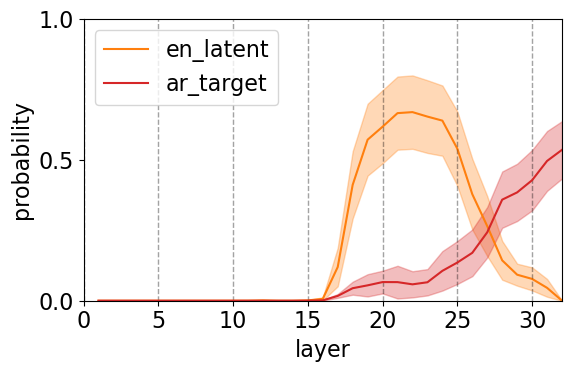

In [108]:
def plot_ci_mk2(ax, data, label, color='blue', linestyle='-', tik_step=5, layer_num=40):

    data = np.array(data)
    for i in range(0, layer_num+1, tik_step):
        ax.axvline(i, color='black', linestyle='--', alpha=0.2, linewidth=1)
    
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std_err = std / np.sqrt(data.shape[0])
    data_ci = {
        'x': np.arange(data.shape[1]) + 1,
        'y': mean,
        'y_upper': mean + 1.96 * std_err,
        'y_lower': mean - 1.96 * std_err,
    }
    df = pd.DataFrame(data_ci)
    ax.plot(df['x'], df['y'], label=label, color=color, linestyle=linestyle)
    ax.fill_between(df['x'], df['y_lower'], df['y_upper'], color=color, alpha=0.3)

def plot_ci_plus_heatmap_mk2(latent_token_probs_1, latent_token_probs_2, out_token_probs, in_token_probs, input_lang, latent_lang_1, latent_lang_2, target_lang, color='blue', tik_step=5, equal=0, layer_num=40):

    fig, ax = plt.subplots(figsize=(6, 4))
    

    if equal == 1:
        plot_ci_mk2(ax, latent_token_probs_1, f'{latent_lang_1}_target', color='tab:orange', tik_step=tik_step, layer_num=layer_num)
    else: 
        plot_ci_mk2(ax, latent_token_probs_1, f'{latent_lang_1}_latent', color='tab:orange', tik_step=tik_step, layer_num=layer_num)
    if equal == 2:
        plot_ci_mk2(ax, latent_token_probs_2, f'{latent_lang_2}_target', color='tab:red', tik_step=tik_step, layer_num=layer_num)
    else:
        plot_ci_mk2(ax, latent_token_probs_2, f'{latent_lang_2}_latent', color='tab:red', tik_step=tik_step, layer_num=layer_num)
    if equal == 0:
        plot_ci_mk2(ax, out_token_probs, f'{target_lang}_target', color='tab:blue', tik_step=tik_step)

    ax.set_xlabel('layer')
    ax.set_ylabel('probability')
    
    ax.set_xlim(0, layer_num)
    ax.set_ylim(0, 1)
    
    ax.set_xticks(np.arange(0, layer_num+1, step=tik_step))
    ax.set_yticks([0, 0.5, 1.0])
    ax.legend(loc='upper left')
    plt.tight_layout()
    return fig, ax


fig, ax = plot_ci_plus_heatmap_mk2(latent_token_probs_1, latent_token_probs_2, out_token_probs, in_token_probs, input_lang, latent_lang_1, latent_lang_2, target_lang, color='tab:orange', tik_step=5, equal=equal, layer_num=layer_num)

plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
# for i in dataset[0]['out_token_id']:
#     alternative_decoded_strings=tokenizer.decode(i)
#     print(alternative_decoded_strings)

In [50]:
# alternative_decoded_strings=tokenizer.decode([29871])
# print(alternative_decoded_strings)

In [22]:
# words2 = '電話'
# print(words2)
# default_tokens = tokenizer.tokenize(words2)
# default_token_ids = tokenizer.convert_tokens_to_ids(default_tokens)
# print("Default tokens:", default_tokens)
# print("Default token IDs:", default_token_ids)
# alternative_decoded_strings=tokenizer.decode(default_token_ids)
# print(alternative_decoded_strings)

電話
Default tokens: ['▁']
Default token IDs: [488]



In [46]:
import torch
import torch.nn.functional as F

def custom_beam_search(model, tokenizer, device, prompt, num_beams=5, max_length=50, layer_id=39):
    prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    all_candidates = []
    all_probabilities = []

    for step in range(max_length):
        if not all_candidates:
            with torch.no_grad():
                outputs = model(prompt_ids)
                layer_output = model.model.layers[layer_id].output
                normed = model.model.norm(layer_output)
                logits = model.lm_head(normed)
                
                probs = F.softmax(logits[:, -1, :], dim=-1)
                top_probs, top_indices = torch.topk(probs, num_beams, dim=1)
            for i in range(num_beams):
                all_candidates.append([top_indices[0, i].item()])
                all_probabilities.append(top_probs[0, i].item())
        else:
            new_candidates = []
            new_probabilities = []

            for i in range(len(all_candidates)):
                candidate_ids = prompt_ids.clone()
                candidate_ids = torch.cat([candidate_ids.squeeze(0), torch.tensor(all_candidates[i], device=device)], dim=0).unsqueeze(0)
                with torch.no_grad():
                    outputs = model(candidate_ids)
                    layer_output = model.model.layers[layer_id].output
                    normed = model.model.norm(layer_output)
                    logits = model.lm_head(normed)
                    probs = F.softmax(logits[:, -1, :], dim=-1)
                    top_probs, top_indices = torch.topk(probs, num_beams, dim=1)
                for j in range(num_beams):
                    new_candidates.append(all_candidates[i] + [top_indices[0, j].item()])
                    new_probabilities.append(all_probabilities[i] * top_probs[0, j].item())

            all_candidates = new_candidates
            all_probabilities = new_probabilities


            top_indices = torch.topk(torch.tensor(all_probabilities), num_beams, largest=True).indices
            all_candidates = [all_candidates[i] for i in top_indices]
            all_probabilities = [all_probabilities[i] for i in top_indices]
    final_results = [tokenizer.decode(candidate) for candidate in all_candidates]
    return list(zip(final_results, all_candidates, all_probabilities))


In [47]:
# layer_idx = 31
# num_beams = 10
# n = 0
# max_length = 3
# prompt = dataset[n]['prompt']
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # prompt = dataset[4].enTja
# results = custom_beam_search(model=model.model, tokenizer=tokenizer, device=device, prompt=prompt, num_beams=num_beams, max_length=max_length, layer_id=layer_idx)
# # results = generate_intermediate_text_with_beam_search_hidden(model=model.model, tokenizer=tokenizer, device=device, layer_idx=39, prompt=prompt, num_beams=num_beams, max_length=max_length)
# for result, id, probability in results:
#     print(f"Sequence: {result}, Ids: {id}, Probability: {probability:.4f}")
# dataset[n]

Sequence: هاتف", Ids: [30204, 33198, 29908], Probability: 0.9903
Sequence: هاتف
, Ids: [30204, 33198, 13], Probability: 0.0013
Sequence: الهاتف", Ids: [34565, 33198, 29908], Probability: 0.0008
Sequence: تليفون", Ids: [30195, 50227, 29908], Probability: 0.0005
Sequence: تلفون, Ids: [30195, 32182, 32027], Probability: 0.0005
Sequence: جوال", Ids: [30270, 32562, 29908], Probability: 0.0002
Sequence: هواتف", Ids: [30204, 36464, 29908], Probability: 0.0002
Sequence: هاتفي", Ids: [33616, 32139, 29908], Probability: 0.0002
Sequence: هاتِف", Ids: [33616, 41782, 29908], Probability: 0.0002
Sequence: هاتف محمول, Ids: [30204, 33198, 43835], Probability: 0.0002


{'prompt': 'عربي: "مشي" - عربي: "مشي"\nعربي: "قضية" - عربي: "قضية"\nعربي: "تمرين" - عربي: "تمرين"\nعربي: "تاريخ" - عربي: "تاريخ"\nعربي: "هاتف" - عربي: "',
 'out_token_id': [[29871, 34948], [34948]],
 'out_token_str': 'هاتف',
 'latent_token_id_1': [[29871, 4382, 6710],
  [29911, 6146, 6710],
  [9699, 6710],
  [4382, 6710],
  [15494, 6710],
  [29871, 9699, 6710]],
 'latent_token_str_1': 'telephone',
 'latent_token_id_2': [[29871, 34948], [34948]],
 'latent_token_str_2': 'هاتف',
 'in_token_str': 'هاتف',
 'in_token_id': [[29871, 34948], [34948]]}